In [19]:
import os
from pathlib import Path
from dotenv import load_dotenv
from typing import List
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import as_completed
import transformers
from transformers import AutoTokenizer
from concurrent.futures import ThreadPoolExecutor
from langchain_core.documents import Document
from langchain_community.graphs import Neo4jGraph
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.llms.huggingface_endpoint import HuggingFaceEndpoint

In [2]:
env_path = os.path.join(Path.cwd().parent, ".env")
load_dotenv(env_path)

True

In [3]:
string_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-405B-Instruct")

#### Loading the LLM

In [4]:
llm=HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3.1-405B-Instruct",
    temperature=1,
    max_new_tokens=5000,
    huggingfacehub_api_token=os.environ.get('HUGGINGFACEHUB_API_TOKEN')
)

/Users/aum/Desktop/Programming/GraphRag/venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aum/.cache/huggingface/token
Login successful


#### Initiating the knowledge graph instance

In [5]:
# NEO4J_URI=""
# NEO4J_USERNAME=""
# NEO4J_PASSWORD=""
graph = Neo4jGraph()
print(graph.schema)

Node properties:

Relationship properties:

The relationships:



#### Counting the tokens

In [6]:
def count_tokens(
        string: str, 
        tokenizer_model: transformers
    ) -> int:
    """Returns the number of tokens in a text string."""
    num_tokens = len(tokenizer_model.encode(string))
    return num_tokens

In [7]:
pubmed_articles = pd.read_csv(
    "../data/pubmed_articles_clean.csv"
)
pubmed_articles["tokens"] = [
    count_tokens(f"{row['full_document']}", tokenizer_model=string_tokenizer)
    for i, row in pubmed_articles.iterrows()
]
pubmed_articles.head()

,PMID,Title,Abstract,Product in focus (Tremfya/Skyrizi/Both/General),Author includes Originator or Company (Y/N),Safety,Efficacy/Effectiveness,Safety+Efficacy,"Others (Treatment/switch patterns, Drug survival)",Details of Others,...,Author(s) Affiliation,Source,Copyright Information,Place of Publication,Articles,doi,origin,pdf link,full_document,tokens
0,32022825,Comparison of Biologics and Oral Treatments fo...,IMPORTANCE: The clinical benefits of novel tre...,General,Y,N,Y,N,N,-,...,"Department of Dermatology, Keck School of Medi...",JAMA Dermatol. 2020 Mar 1;156(3):258-269. doi:...,-,United States,\n\nKey PointsQuestion \r\n What is the short\...,10.1001/jamadermatol.2019.4029,JAMA Dermatol,https://doi.org/10.1001/jamadermatol.2019.4029,Comparison of Biologics and Oral Treatments fo...,19901
1,34518264,IL-23 blockade with guselkumab potentially mod...,BACKGROUND: Guselkumab is an interleukin (IL)-...,Tremfya,Y,N,Y,N,N,-,...,"Department of Medicine, Division of Dermatolog...",BMJ Open. 2021 Sep 13;11(9):e049822. doi: 10.1...,(c) Author(s) (or their employer(s)) 2021. Re-...,England,\n\n\n\n\n\n\n\nPDF\n\n\n\n\n\n\n\n\n\nXML \n\...,10.1136/bmjopen-2021-049822,BMJ Open,https://doi.org/10.1136/bmjopen-2021-049822,IL-23 blockade with guselkumab potentially mod...,16318
2,37330926,Safety of IL-23 p19 Inhibitors for the Treatme...,The approved biologics targeting interleukin (...,General,N,Y,N,N,N,-,...,"Oregon Medical Research Center, 9495 SW Locust...",Adv Ther. 2023 Aug;40(8):3410-3433. doi: 10.10...,(c) 2023. The Author(s).,United States,\nAbstractThe approved biologics targeting int...,10.1007/s12325-023-02568-0,Adv Ther,https://doi.org/10.1007/s12325-023-02568-0,Safety of IL-23 p19 Inhibitors for the Treatme...,18336
3,37256136,Adverse events with risankizumab in the real w...,"BACKGROUND: Risankizumab, a humanized IgG1 mon...",Skyrizi,N,Y,N,N,N,-,...,"Department of Pharmacy, Tongji Hospital, Tongj...",Front Immunol. 2023 May 15;14:1169735. doi: 10...,"Copyright (c) 2023 Shu, Chen, Ding and Zhang.",Switzerland,Yamin Shu1Jing Chen1Yiling Ding2Qilin Zhang3\*...,10.3389/fimmu.2023.1169735,Front Immunol,https://doi.org/10.3389/fimmu.2023.1169735,Adverse events with risankizumab in the real w...,12814
4,35996400,"Guselkumab, Risankizumab, and Tildrakizumab in...","Interleukin (IL)-23 inhibitors, guselkumab, ri...",General,N,Y,Y,Y,N,-,...,"Department of Clinical Medicine and Surgery, S...",Clin Cosmet Investig Dermatol. 2022 Aug 16;15:...,(c) 2022 Ruggiero et al.,New Zealand,"\nAngelo Ruggiero, Vincenzo Picone, Fabrizio M...",10.2147/CCID.S364640,Clin Cosmet Investig Dermatol,https://doi.org/10.2147/CCID.S364640,"Guselkumab, Risankizumab, and Tildrakizumab in...",13984


In [8]:
# Filter relevant articles for this exercise
random_sampled_articles_df = pubmed_articles.sample(n=50, random_state=42)

In [9]:
random_sampled_articles_df["Product in focus (Tremfya/Skyrizi/Both/General)"].value_counts()

Product in focus (Tremfya/Skyrizi/Both/General)
Tremfya    19
Skyrizi    17
General    13
Both        1
Name: count, dtype: int64

In [10]:
pubmed_articles["Product in focus (Tremfya/Skyrizi/Both/General)"].value_counts()

Product in focus (Tremfya/Skyrizi/Both/General)
Tremfya    38
Skyrizi    38
General    26
Both        1
Name: count, dtype: int64

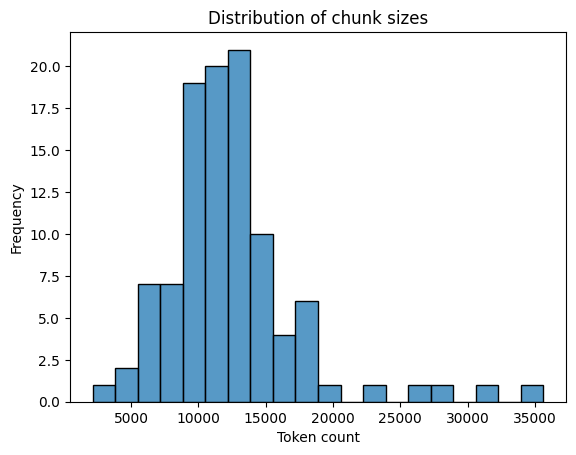

In [11]:
# Plot for all articles
sns.histplot(pubmed_articles["tokens"], kde=False)
plt.title('Distribution of chunk sizes')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.show()

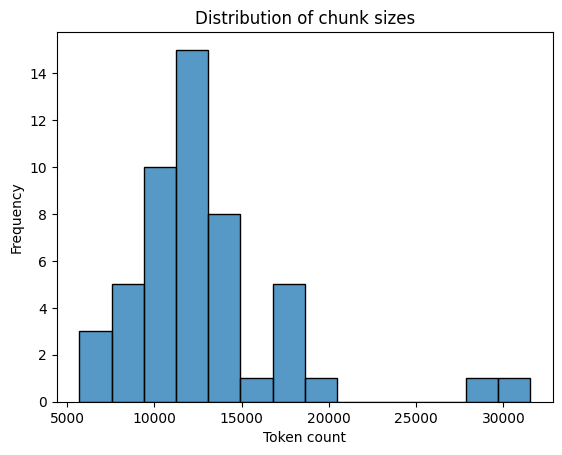

In [12]:
# Plot for randomly selected articles
sns.histplot(random_sampled_articles_df["tokens"], kde=False)
plt.title('Distribution of chunk sizes')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.show()

#### Chunking and processing

In [13]:
# Convert the data to documents; considering only the first 50 articles
article_documents = [
    Document(page_content=row['full_document'])
    for _, row in random_sampled_articles_df.iterrows()
]

print(f"Total documents before chunking -> {len(article_documents)}")

# Define the chunk size and overlap
chunk_size = 1000  # Characters per chunk
overlap = 300      # Characters to overlap between chunks

# Create a text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, 
    chunk_overlap=overlap
)

# Chunk the documents
chunked_documents = []
for each_article in article_documents:
    chunks = text_splitter.split_text(each_article.page_content)
    chunked_documents.extend(
        Document(page_content=each_chunk)
        for each_chunk in chunks
    )

print(f"Total documents after chunking -> {len(chunked_documents)}")

Total documents before chunking -> 50
Total documents after chunking -> 3607


In [14]:
llm_transformer = LLMGraphTransformer(
    llm=llm, 
    allowed_nodes=[
        "Drug-Tremfya",
        "Drug-Guselkumab",
        "Drug-Skyrizi",
        "Drug-Risankizumab",
        "Treatment",
        "Patient",
        "Comorbidity",
    ],
    allowed_relationships=[
        "Treatment outcome",
        "Clinical outcome",
        "Adverse events",
        "Survival",
        "Efficacy",
        "Safety"
    ],
    # node_properties=["description"],  # Disabling as LLAMA 3 doesn't support native function calling
    # relationship_properties=["description"]  # Disabling as LLAMA 3 doesn't support native function calling
)

def process_text(
        document_text: Document
    ) -> List:
    return llm_transformer.convert_to_graph_documents([document_text])

In [20]:
MAX_WORKERS = 10
graph_documents = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(process_text, each_chunk_document)
        for each_chunk_document in chunked_documents
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        graph_document = future.result()
        graph_documents.extend(graph_document)

graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processing documents:   0%|          | 0/3607 [00:00<?, ?it/s]


HfHubHTTPError: 429 Client Error: Too Many Requests for url: https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3.1-405B-Instruct (Request ID: 8KEy9aMBfKvj5U1no_KBc)

Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate